In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from census import Census
from us import states

import ipdb

# Data Processing
## Including land use data *and* trip data (OD)

In [2]:
# trip data -> OD

In [3]:
# # land use and Census data
# ## path of the data offered by Han Wang
# path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/HW - EPCs_ACS2018_tbl.csv'
# demographic_result = pd.read_csv(path)
# demographic_result.T

In [4]:
# Access shapefile of California census tracts, 06 represents CA
# Census tracts data 只到tract level，但是smart location data到了census block group level
# 所以smart location data更细
ca_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
ca_tract = ca_tract
ca_tract = ca_tract[['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON']]
# ca_tract.plot()

In [5]:
# smart location data url: https://www.epa.gov/smartgrowth/smart-location-database-technical-documentation-and-user-guide
sl_path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/Smart Location Data Export.csv'
sl_data = pd.read_csv(sl_path)[[
    'OBJECTID', 'GEOID20', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p',\
    'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C', 'D4D', \
    'D5AR', 'D5AE', 'NatWalkInd', 'TotPop'
]]

In [6]:
sl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220739 entries, 0 to 220738
Data columns (total 24 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   OBJECTID     220739 non-null  int64  
 1   GEOID20      220739 non-null  int64  
 2   CSA          167709 non-null  float64
 3   CSA_Name     167709 non-null  object 
 4   CBSA         203645 non-null  float64
 5   CBSA_Name    203645 non-null  object 
 6   AutoOwn0     220739 non-null  int64  
 7   AutoOwn1     220739 non-null  int64  
 8   AutoOwn2p    220739 non-null  int64  
 9   TotEmp       220739 non-null  int64  
 10  E_LowWageWk  220739 non-null  int64  
 11  E_MedWageWk  220739 non-null  int64  
 12  E_HiWageWk   220739 non-null  int64  
 13  D1B          220739 non-null  float64
 14  D1C          220739 non-null  float64
 15  D3A          220739 non-null  float64
 16  D4A          220739 non-null  float64
 17  D4B050       220739 non-null  float64
 18  D4C          220739 non-

In [7]:
sl_data['GEOID'] = sl_data['GEOID20'] // 10
sl_data['COUNTYID'] = sl_data['GEOID20'] // 1e7

In [8]:
ca_tract['TotPop'] = ''
for i in ca_tract.index:
    geoid = int(ca_tract.loc[i, 'GEOID'])
    ca_tract.loc[i, 'TotPop'] = sl_data.loc[sl_data['GEOID']==geoid, 'TotPop'].sum()

In [9]:
def add_att(att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    ca_tract[att] = ''
    for i in ca_tract.index:
        geoid = int(ca_tract.loc[i, 'GEOID'])
        if type_ == 'sum':
            ca_tract.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].sum()
        elif type_ == 'mean':
            ca_tract.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].mean()
        elif type_ == 'same':
            ca_tract.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].iloc[0]
            

In [10]:
att_lst = [
    'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p',\
    'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C', 'D4D', \
    'D5AR', 'D5AE', 'NatWalkInd', 'TotPop'
]

type_lst = [
    'same', 'same', 'same', 'same', 'sum', 'sum', 'sum',\
    'sum', 'sum', 'sum', 'sum', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',\
    'sum', 'sum', 'mean', 'sum'
]

assert(len(att_lst) == len(type_lst))

In [11]:
# may spend around 1.5 minutes
for i in range(len(att_lst)):
#     print(i)
    add_att(att_lst[i], type_lst[i])

In [12]:
for i in ca_tract.index:
    ca_tract.loc[i, 'COUNTYID'] = ca_tract.loc[i, 'GEOID'][:5]

att_lst.append('COUNTYID')
att_lst.append('GEOID')
type_lst.append('same')
type_lst.append('same')

In [13]:
ca_tract.head(2)

,GEOID,geometry,INTPTLAT,INTPTLON,TotPop,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,...,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,COUNTYID
0,06037139301,"POLYGON ((-118.57150 34.17758, -118.57148 34.1...",+34.1781538,-118.5581265,4590,348.0,"Los Angeles-Long Beach, CA",31080.0,"Los Angeles-Long Beach-Anaheim, CA",22,...,1.69166,20.584907,791.706667,0.57606,13.113333,36.26638,676676,565943,13.333333,06037
1,06037139302,"POLYGON ((-118.54073 34.18019, -118.54070 34.1...",+34.1767230,-118.5383655,5549,348.0,"Los Angeles-Long Beach, CA",31080.0,"Los Angeles-Long Beach-Anaheim, CA",236,...,10.444677,20.153137,386.24,0.955044,8.335,127.53158,507768,428507,12.5,06037


In [14]:
sl_data.head(2)

,OBJECTID,GEOID20,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,...,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,TotPop,GEOID,COUNTYID
0,1,481130078254,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",69,39,315,66,...,362.10,0.000000,4.33,37.654717,433601,303660,14.000000,1202,48113007825,48113.0
1,2,481130078252,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",0,168,241,25,...,718.84,0.009516,4.33,23.126113,386504,272135,10.833333,710,48113007825,48113.0


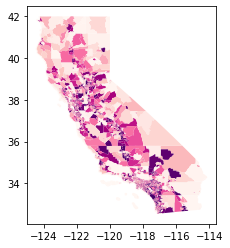

In [15]:
# Create subplots
fig = plt.figure()
ax = fig.add_subplot(111)

im = ca_tract.plot(column = 'TotPop', cmap='RdPu', ax=ax)
# fig.savefig('cal.svg', format='svg')

In [16]:
from shapely.ops import unary_union

def get_county_data():
    # 新建一个表格，找出各个county的数据（通过合并各个county的tract来实现）
    county_lst = ca_tract['COUNTYID'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'COUNTYID', 'geometry']
    county_data = gpd.GeoDataFrame(columns=col_, index=range(len(county_lst)))
    
    for i in range(len(county_lst)):
        this_county_id = county_lst.iloc[i]
        this_county = ca_tract[ca_tract['COUNTYID']==this_county_id]
        polygons = this_county['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        county_data.loc[i, 'geometry'] = boundary.values
        county_data.loc[i, 'COUNTYID'] = this_county_id
        county_data.loc[i, 'TotPop'] = this_county['TotPop'].sum()
        
    return county_data

In [17]:
ca_county = get_county_data()

<AxesSubplot:>

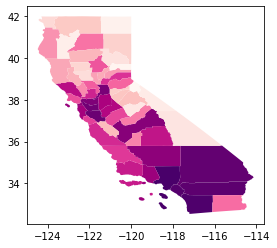

In [18]:
# Create subplots
fig = plt.figure()
ax = fig.add_subplot(111)

ca_county.plot(column = 'TotPop', cmap='RdPu', ax=ax)

## Landuse data (Smart Location)

In [19]:
def plot_area_by_pop(CBSA):
    # plot an area by population, input: CBSA name
    temp = ca_tract.loc[ca_tract['CBSA_Name']==CBSA]
    fig = plt.figure(figsize=[10,20])
    ax = fig.add_subplot(111)
    temp.plot(ax=ax, column='TotPop', cmap='RdPu')
    return fig

In [20]:
# fig = plot_area_by_pop('San Francisco-Oakland-Berkeley, CA')
# fig.savefig('bay_area.svg', format='svg')

In [21]:
station_coor = pd.read_csv(
    '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/station-coor.csv', index_col=0
)
station_coor.head(2)

,abbr,lat,lon
0,12TH,37.803768,-122.271450
1,16TH,37.765062,-122.419694


In [22]:
ca_tract[['INTPTLAT', 'INTPTLON']] = ca_tract[['INTPTLAT', 'INTPTLON']].astype(float)
ca_tract

,GEOID,geometry,INTPTLAT,INTPTLON,TotPop,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,...,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,COUNTYID
0,06037139301,"POLYGON ((-118.57150 34.17758, -118.57148 34.1...",34.178154,-118.558127,4590,348.0,"Los Angeles-Long Beach, CA",31080.0,"Los Angeles-Long Beach-Anaheim, CA",22,...,1.69166,20.584907,791.706667,0.57606,13.113333,36.26638,676676,565943,13.333333,06037
1,06037139302,"POLYGON ((-118.54073 34.18019, -118.54070 34.1...",34.176723,-118.538365,5549,348.0,"Los Angeles-Long Beach, CA",31080.0,"Los Angeles-Long Beach-Anaheim, CA",236,...,10.444677,20.153137,386.24,0.955044,8.335,127.53158,507768,428507,12.5,06037
2,06037139502,"POLYGON ((-118.53225 34.16201, -118.53177 34.1...",34.162840,-118.526311,2856,348.0,"Los Angeles-Long Beach, CA",31080.0,"Los Angeles-Long Beach-Anaheim, CA",25,...,3.795625,23.935872,435.19,0.0,8.0,39.651604,450585,377949,16.583333,06037
3,06037139600,"POLYGON ((-118.51858 34.15858, -118.51858 34.1...",34.164060,-118.510100,4803,348.0,"Los Angeles-Long Beach, CA",31080.0,"Los Angeles-Long Beach-Anaheim, CA",70,...,8.358791,17.94273,549.185,0.0,10.665,22.432592,512374,427511,16.083333,06037
4,06037139701,"POLYGON ((-118.50980 34.15691, -118.50848 34.1...",34.157429,-118.495412,5336,348.0,"Los Angeles-Long Beach, CA",31080.0,"Los Angeles-Long Beach-Anaheim, CA",69,...,15.211208,17.929219,-19738.82,0.0,11.732,56.227418,1536142,1277774,13.633333,06037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,06001443001,"POLYGON ((-121.95760 37.52392, -121.95745 37.5...",37.518422,-121.951524,3046,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",10,...,0.733511,24.889144,493.53,0.006533,4.33,14.588858,161233,133083,13.666667,06001
8053,06001443002,"POLYGON ((-121.96900 37.52248, -121.96885 37.5...",37.516834,-121.960592,6745,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",26,...,0.874175,30.534006,654.47,0.0,4.0,21.465629,532376,419094,14.055556,06001
8054,06001443102,"POLYGON ((-121.93952 37.51476, -121.93926 37.5...",37.507224,-121.927149,4881,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",28,...,0.598466,25.924359,537.1175,0.116977,4.5825,21.915142,596942,498701,13.166667,06001
8055,06001443301,"POLYGON ((-121.92094 37.47505, -121.92092 37.4...",37.470732,-121.912956,4343,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",10,...,0.474837,28.121929,498.9,0.0,4.0,18.328927,337078,279812,12.833333,06001


In [23]:
# to drop distant (from any stations) areas
# interate each station, drop distant tract from ca_tract

dist_lmt = 0.05
print('The catchment radius is around %.3f km, %.3f mile'%(dist_lmt*111, dist_lmt*111/1.6))

ca_tract['if_keep'] = np.nan
ca_tract['nearest station'] = np.nan
ca_tract['transit distance [km]'] = 10000
att_lst.extend(['if_keep', 'nearest station', 'transit distance [km]', 'INTPTLAT', 'INTPTLON'])
type_lst.extend(['same', 'same', 'mean', 'mean', 'mean'])  # 'transit distance [km]' is useless after mean


for i in station_coor.index:
    station_lat = station_coor.loc[i, 'lat']
    station_lon = station_coor.loc[i, 'lon']
    station_name = station_coor.loc[i, 'abbr']
    
    dist_df_temp = np.sqrt((ca_tract['INTPTLAT'] - station_lat)**2 + (ca_tract['INTPTLON'] - station_lon)**2)

    ca_tract.loc[dist_df_temp < dist_lmt, 'if_keep'] = 1
    for j in ca_tract.loc[ca_tract['if_keep']==1].index:
        currrent_dist = dist_df_temp.loc[j]
        if ca_tract.loc[j, 'transit distance [km]'] > currrent_dist*111:  # 假如遇到了更近的站
            ca_tract.loc[j, 'transit distance [km]'] = currrent_dist*111
            ca_tract.loc[j, 'nearest station'] = station_name
    

The catchment radius is around 5.550 km, 3.469 mile


<AxesSubplot:>

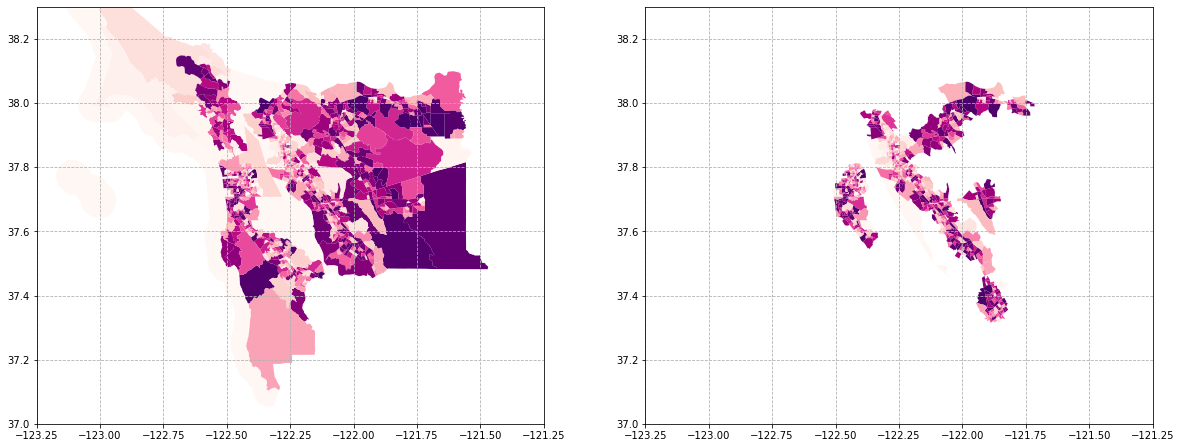

In [31]:
ca_tract_nearbart = ca_tract.loc[ca_tract['if_keep']==1]
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xlim([-123.25, -121.25])
ax1.set_ylim([37, 38.3])
ax1.grid(ls='--')
ax2.set_xlim([-123.25, -121.25])
ax2.set_ylim([37, 38.3])
ax2.grid(ls='--')

ca_tract.loc[ca_tract['CBSA_Name']=='San Francisco-Oakland-Berkeley, CA'].plot(column='TotPop', ax=ax1, cmap='RdPu')
ca_tract_nearbart.plot(column='TotPop', ax=ax2, cmap='RdPu')


<AxesSubplot:>

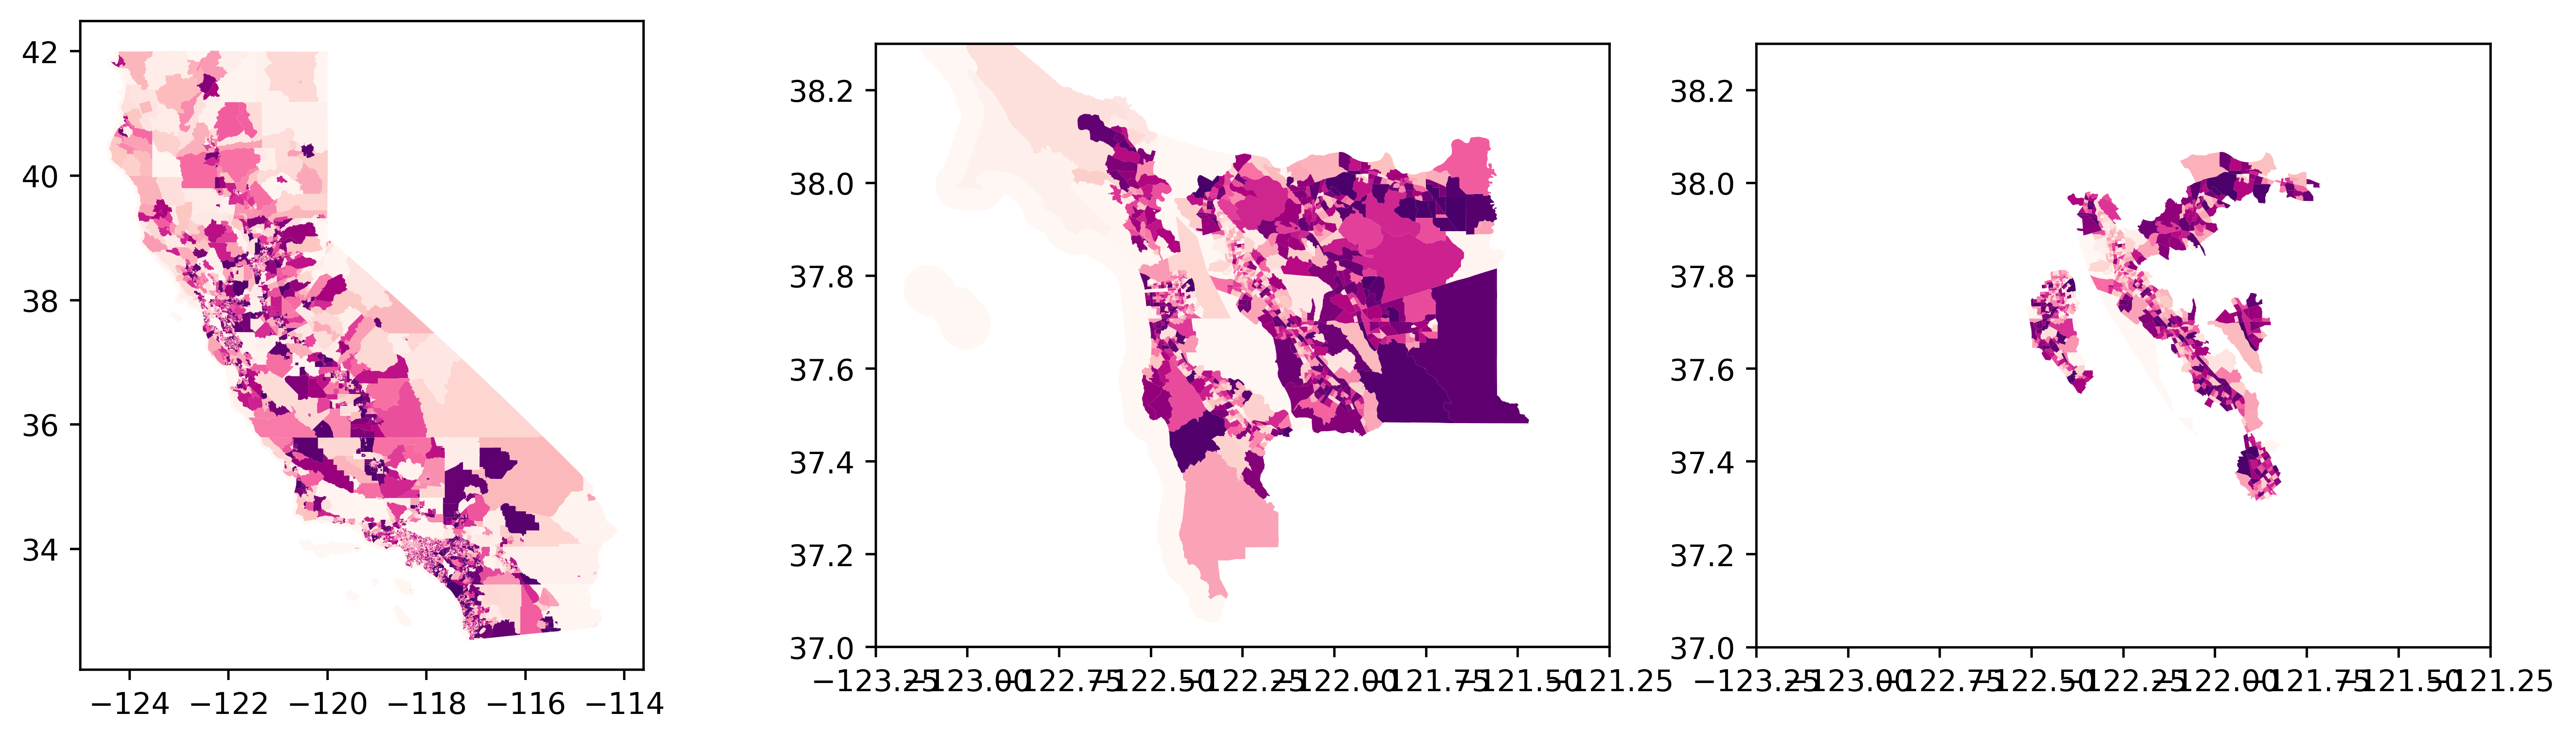

In [35]:
# For write up for data
fig = plt.figure(figsize=[15, 4], dpi=500)
ax0 = fig.add_subplot(131)


im = ca_tract.plot(column = 'TotPop', cmap='RdPu', ax=ax0)
# fig.savefig('cal.svg', format='svg')

ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
ax1.set_xlim([-123.25, -121.25])
ax1.set_ylim([37, 38.3])
ax2.set_xlim([-123.25, -121.25])
ax2.set_ylim([37, 38.3])

ca_tract.loc[ca_tract['CBSA_Name']=='San Francisco-Oakland-Berkeley, CA'].plot(column='TotPop', ax=ax1, cmap='RdPu')
ca_tract_nearbart.plot(column='TotPop', ax=ax2, cmap='RdPu')

In [36]:
ca_tract_nearbart.head(2)

,GEOID,geometry,INTPTLAT,INTPTLON,TotPop,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,...,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,COUNTYID,if_keep,nearest station,transit distance [km]
6,06013324002,"POLYGON ((-122.07313 37.94793, -122.07276 37.9...",37.951498,-122.060561,5305,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",126,...,0.0,3.446667,12.072633,321636,288180,16.833333,06013,1.0,PHIL,2.605781
8,06013336201,"POLYGON ((-122.05390 37.95307, -122.05286 37.9...",37.960462,-122.047502,3966,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",109,...,0.0,-33330.89,-33310.783597,258203,236456,12.166667,06013,1.0,CONC,2.519122


In [37]:
ca_tract_nearbart.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 739 entries, 6 to 8055
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   GEOID                  739 non-null    object  
 1   geometry               739 non-null    geometry
 2   INTPTLAT               739 non-null    float64 
 3   INTPTLON               739 non-null    float64 
 4   TotPop                 739 non-null    object  
 5   CSA                    739 non-null    object  
 6   CSA_Name               739 non-null    object  
 7   CBSA                   739 non-null    object  
 8   CBSA_Name              739 non-null    object  
 9   AutoOwn0               739 non-null    object  
 10  AutoOwn1               739 non-null    object  
 11  AutoOwn2p              739 non-null    object  
 12  TotEmp                 739 non-null    object  
 13  E_LowWageWk            739 non-null    object  
 14  E_MedWageWk            739 non-nu

In [38]:
# OD matrix follows the stops order as follows
stops = pd.read_csv('/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/stops_order.csv', index_col=0)

In [39]:
# data_X_all means with all attributes
data_X_all = gpd.GeoDataFrame(np.nan, index=range(50), columns=ca_tract_nearbart.columns)
data_X_all['nearest station'] = stops

In [40]:
data_X_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   GEOID                  0 non-null      float64 
 1   geometry               0 non-null      geometry
 2   INTPTLAT               0 non-null      float64 
 3   INTPTLON               0 non-null      float64 
 4   TotPop                 0 non-null      float64 
 5   CSA                    0 non-null      float64 
 6   CSA_Name               0 non-null      float64 
 7   CBSA                   0 non-null      float64 
 8   CBSA_Name              0 non-null      float64 
 9   AutoOwn0               0 non-null      float64 
 10  AutoOwn1               0 non-null      float64 
 11  AutoOwn2p              0 non-null      float64 
 12  TotEmp                 0 non-null      float64 
 13  E_LowWageWk            0 non-null      float64 
 14  E_MedWageWk            0 non-null   

In [41]:
for i in stops.index:
    station = stops.loc[i, 'stop']
    for j in range(len(att_lst)):
        att = att_lst[j]
        type_ = type_lst[j]

        if type_ == 'sum':
            data_X_all.loc[data_X_all['nearest station']==station, att] = \
                ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, att].sum()
        elif type_ == 'mean':
            data_X_all.loc[data_X_all['nearest station']==station, att] = \
                ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, att].mean()
        elif type_ == 'same':
            data_X_all.loc[data_X_all['nearest station']==station, att] = \
                ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, att].iloc[0]

    # union the geometry
    polygons = ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, 'geometry']
    boundary = gpd.GeoSeries(unary_union(polygons))
    
    data_X_all.loc[data_X_all['nearest station']==station, 'geometry'] = boundary.values
    

<AxesSubplot:>

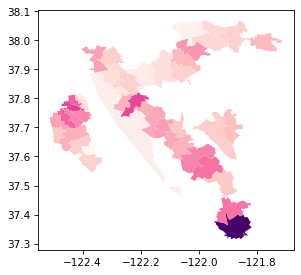

In [42]:
fig = plt.figure(figsize=[15, 5], dpi=75)
ax0 = fig.add_subplot(131)

data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')

In [44]:
# data_X_all.to_file('./data/data_X_all.shp', driver='ESRI Shapefile')

In [45]:
data_X = data_X_all.drop([
    'GEOID', 'geometry', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name',\
    'COUNTYID', 'if_keep', 'transit distance [km]'
], axis=1)

try:
    assert(data_X.shape[1]==21)
except:
    del data_X
    raise Exception('Number of features not correct!')

In [46]:
data_X

,INTPTLAT,INTPTLON,TotPop,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageWk,E_MedWageWk,E_HiWageWk,...,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,nearest station
0,37.804224,-122.277150,11084.0,1664.0,2208.0,1087.0,33120.0,4730.0,5453.0,22937.0,...,66.359459,42.232657,202.284167,0.671014,71.028333,707.012491,1891149.0,1455141.0,16.972222,12TH
1,37.769279,-122.436020,142973.0,20505.0,29075.0,14224.0,103479.0,14244.0,20339.0,68896.0,...,24.433092,32.296762,253.348446,0.652203,30.318892,697.115918,16339411.0,11103193.0,16.600806,16TH
2,37.813755,-122.259830,36177.0,4704.0,10569.0,4185.0,47570.0,6992.0,9447.0,31131.0,...,41.281070,31.822631,277.895303,0.236281,35.711818,536.360791,5676596.0,4534421.0,15.866162,19TH
3,37.743146,-122.407075,104191.0,8018.0,16354.0,12794.0,39663.0,7690.0,12421.0,19552.0,...,9.285187,32.894203,232.868000,0.644984,29.592795,601.787200,12070958.0,8385313.0,16.382372,24TH
4,37.991232,-121.783599,70630.0,1142.0,5758.0,15314.0,13924.0,3702.0,4904.0,5318.0,...,1.723090,20.531431,-99999.000000,0.051374,-82049.645385,-82049.033490,1115714.0,1725648.0,8.331197,ANTC
5,37.849051,-122.275761,47031.0,2693.0,9557.0,7511.0,19304.0,3880.0,4816.0,10608.0,...,8.100180,30.456888,257.382798,0.432034,18.811845,249.618301,6743180.0,5317925.0,16.257937,ASHB
6,37.729215,-122.455668,123382.0,3871.0,13763.0,21748.0,16384.0,5010.0,5282.0,6092.0,...,4.243723,29.802149,-1839.354737,0.662504,-2147.353553,-1785.497463,10236657.0,9095305.0,15.223033,BALB
7,37.694254,-122.128025,92905.0,1949.0,9736.0,18912.0,21128.0,5134.0,6888.0,9106.0,...,2.531293,24.243937,-2272.098056,0.072759,10.115972,66.018047,8022463.0,7263135.0,13.201389,BAYF
8,37.696267,-122.073219,61232.0,1276.0,6304.0,14890.0,11796.0,3246.0,4084.0,4466.0,...,2.991047,20.000183,-5667.073972,0.140720,-1659.986403,-1631.803448,4125921.0,3815354.0,13.455324,CAST
9,37.789188,-122.428223,125375.0,32395.0,26639.0,9045.0,113812.0,19819.0,26697.0,67296.0,...,48.022520,32.944622,238.106602,0.531609,-608.041000,476.068298,12481998.0,7388888.0,16.251165,CIVC


## Ridership data (BART)
### Processed by file "bart_data.py"

In [35]:
# bart_path_raw = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/date-hour-soo-dest-2019.csv'
# bart_data_raw = pd.read_csv(bart_path_raw, header=None)
# bart_data_raw.shape

# output: (10114285, 5)

In [36]:
# bart_path_4d = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/all.npy'
# bart_data_4d = np.load(file=bart_path_4d)

In [37]:
# bart_3d_path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/3d.npy'
# bart_data_3d = np.load(file=bart_3d_path)

In [38]:
bart_2d_annual_path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/2d_annual.npy'
bart_data = np.load(file=bart_2d_annual_path)


(50, 50)


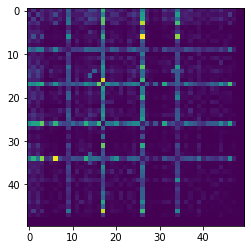

In [39]:
plt.imshow(bart_data)
print(bart_data.shape)

In [46]:
# pd.DataFrame(bart_data, index=stops['stop'].values, columns=stops['stop'].values).to_csv('/Users/kaihangzhang/Downloads/GitHub/Deep_Gravity/data/OD.csv')
